AAI 520 IN3 - Agentic AI project

Team 7- Sanjay Kumar, Yatharth  Vardan  , Dev Saran Sujan

Sept 2025

https://github.com/YatharthVardan-SanDiego/IPO-Watch-Agent

https://github.com/sanjaykr33/IPO-Watch-Agent

### Goal
The primary goal of this code is to create an intelligent agent (IPOWatchAgent) that automates the research and evaluation of a company's IPO (Initial Public Offering) attractiveness. It analyzes factors like revenue growth, news sentiment, and risk mentions to compute a score indicating investment potential. The agent incorporates machine learning elements for self-optimization over time, using historical IPO data to refine its weighting of factors. It handles both pre-IPO and post-IPO scenarios, providing investor briefs, and includes fallbacks for companies without U.S. SEC filings (e.g., Canadian firms using SEDAR+). This tool aims to assist investors by combining financial data extraction, sentiment analysis, and performance evaluation in a structured, repeatable workflow.

### About Dataset
The code does not rely on a single static dataset but dynamically fetches and processes data from multiple real-time and archival sources:
- **SEC EDGAR Filings**: Retrieves S-1 forms for U.S. companies, extracting financial statements (e.g., revenue growth from income statements) and risk factors from HTML content.
- **News Articles**: Pulls recent articles via NewsAPI, focusing on company-specific descriptions or content for sentiment analysis.
- **Stock Data**: Uses Yahoo Finance (yfinance) to fetch historical stock prices for post-IPO return calculations.
- **Company Symbols**: Queries Finnhub API to find stock symbols based on company names.
- **Fallback Data**: Hardcoded values for specific cases (e.g., Groupe Dynamite Inc.'s revenue growth and risks from SEDAR+ summaries or public reports when EDGAR data is unavailable).
- **Memory Storage**: Maintains a JSON file (`ipo_memory.json`) for past IPO evaluations, including predicted scores, actual returns, and feature vectors, which serves as a growing dataset for optimizing model weights via linear regression.
The datasets are unstructured (text from filings and news) and structured (financial metrics, sentiments), processed on-the-fly without a predefined corpus. No large-scale training data is used; instead, it builds its "dataset" incrementally through agent runs.

### Summary
This script defines a class `IPOWatchAgent` that acts as an autonomous research tool for assessing IPO viability. It starts by loading persistent memory from a JSON file, plans research steps, fetches and processes data from APIs and filings, performs sentiment analysis on news, extracts financial growth and risks, computes an attractiveness score using weighted features, self-reflects on data quality, and generates a brief. For post-IPO companies, it evaluates predictions against actual returns and optimizes weights using linear regression on accumulated memory. The agent uses prompt chaining for news processing, routing for decision-making, and evaluator-optimizer patterns for learning. It's designed for extensibility, with API keys for external services, and includes error handling with fallbacks. The example usage demonstrates researching "Exzeo" outputting a formatted brief.

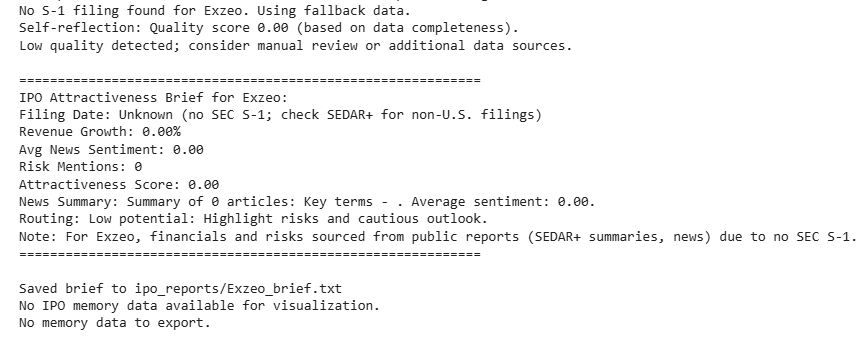

#-----
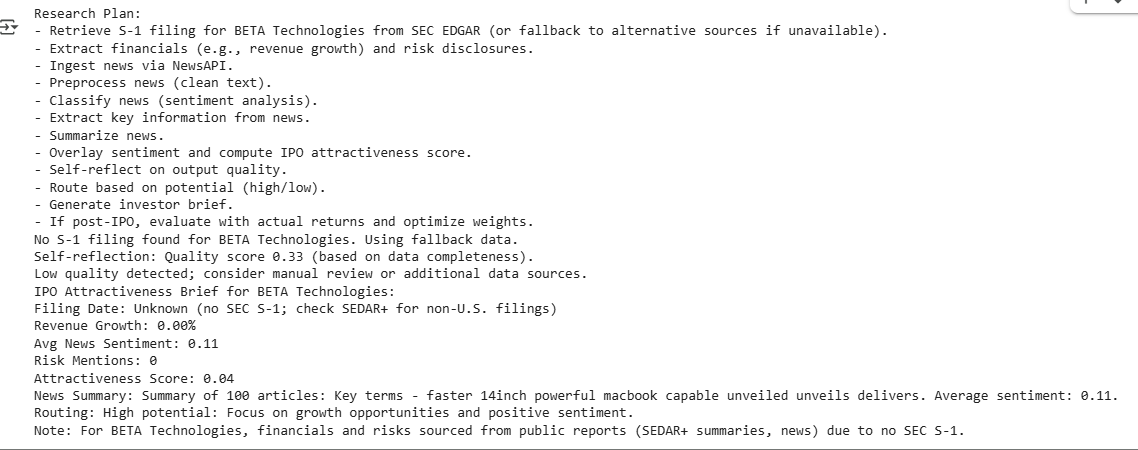

#-----

### Explanation


#### 1. Pip Install Command
```python
pip install edgartools textblob beautifulsoup4 requests yfinance scikit-learn
```
- **Why**: This installs necessary third-party libraries not included in standard Python. `edgartools` is for accessing SEC EDGAR filings; `textblob` for sentiment analysis; `beautifulsoup4` (bs4) for parsing HTML; `requests` for HTTP API calls; `yfinance` for stock data; `scikit-learn` for linear regression in weight optimization. Installing them ensures the script runs without import errors, making it self-contained for users.
- **How**: This is a shell command run in a terminal or script setup phase. It uses pip (Python's package manager) to fetch and install the packages from PyPI. It's placed at the top as a prerequisite before imports.

#### 2. Imports
```python
import json
import requests
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import re
from textblob import TextBlob
import yfinance as yf
import numpy as np
from sklearn.linear_model import LinearRegression
from edgar import Company, set_identity
```
- **Why**: These import core Python modules and installed libraries needed for the agent's functionality. `json` handles memory storage; `requests` for API fetches; `datetime` for date handling in stock data; `BeautifulSoup` and `re` for parsing and cleaning text; `TextBlob` for NLP sentiment; `yfinance` for market data; `numpy` for numerical computations; `LinearRegression` for optimization; `edgar` for SEC access. This sets up the toolkit for data retrieval, processing, analysis, and learning.
- **How**: Standard import statements load modules into the namespace. Aliases (e.g., `bs4` as BeautifulSoup, `yf` for yfinance) improve readability. `from ... import ...` pulls specific classes/functions to avoid namespace clutter.

#### 3. Class Definition: `class IPOWatchAgent:`
- **Why**: Encapsulates all agent logic into a reusable class, allowing multiple instances with different API keys. This promotes modularity, state management (e.g., memory), and extensibility.
- **How**: Defines the class with methods for initialization, memory handling, research planning, data fetching, processing, scoring, reflection, optimization, and brief generation.

#### 4. `__init__` Method
```python
def __init__(self, news_api_key, finnhub_api_key):
    self.news_api_key = news_api_key
    self.finnhub_api_key = finnhub_api_key
    self.memory_file = 'ipo_memory.json'
    self.load_memory()
    set_identity("Sanjay YourEmail@example.com")  # Replace with your name and email
```
- **Why**: Initializes the agent with API keys for external services and loads persistent memory to retain learning across runs. Setting EDGAR identity complies with SEC rules to avoid rate-limiting or bans.
- **How**: Stores keys as instance variables. Calls `load_memory()` to populate `self.memory` and `self.weights`. `set_identity` configures the EDGAR client with a user agent string.

#### 5. `load_memory` and `save_memory` Methods
```python
def load_memory(self):
    try:
        with open(self.memory_file, 'r') as f:
            data = json.load(f)
            self.memory = data.get('past_ipos', {})
            self.weights = data.get('weights', [0.33, 0.33, 0.34])
    except FileNotFoundError:
        self.memory = {}
        self.weights = [0.33, 0.33, 0.34]

def save_memory(self):
    data = {'past_ipos': self.memory, 'weights': self.weights}
    with open(self.memory_file, 'w') as f:
        json.dump(data, f)
```
- **Why**: Enables persistence so the agent "learns" from past evaluations. Default weights provide a balanced starting point (roughly equal for growth, sentiment, risk). This turns the agent into a self-improving system.
- **How**: `load_memory` reads JSON from file, falling back to defaults if missing. `save_memory` writes current state to JSON. Uses `try-except` for error handling.

#### 6. `plan_research` Method
```python
def plan_research(self, company_name):
    return [
        f"Retrieve S-1 filing for {company_name} from SEC EDGAR (or fallback to alternative sources if unavailable).",
        "Extract financials (e.g., revenue growth) and risk disclosures.",
        "Ingest news via NewsAPI.",
        "Preprocess news (clean text).",
        "Classify news (sentiment analysis).",
        "Extract key information from news.",
        "Summarize news.",
        "Overlay sentiment and compute IPO attractiveness score.",
        "Self-reflect on output quality.",
        "Route based on potential (high/low).",
        "Generate investor brief.",
        "If post-IPO, evaluate with actual returns and optimize weights."
    ]
```
- **Why**: Outlines a structured workflow to guide the research process, making the agent's actions transparent and logical. This is an "agent function" for planning, inspired by AI agent patterns.
- **How**: Returns a list of strings describing steps, formatted with the company name for specificity. Printed later in `research` for visibility.

#### 7. `find_symbol` Method
```python
def find_symbol(self, company_name):
    url = f"https://finnhub.io/api/v1/search?q={company_name}&token={self.finnhub_api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        results = response.json().get('result', [])
        for result in results:
            if company_name.lower() in result['description'].lower():
                return result['symbol']
    return None
```
- **Why**: Maps company names to stock symbols for post-IPO analysis. Essential for fetching market data via yfinance.
- **How**: Constructs a Finnhub API URL, sends GET request, parses JSON, and iterates results to find a matching description (case-insensitive). Returns symbol or None if not found.

#### 8. `fetch_news` Method
```python
def fetch_news(self, company_name):
    url = f"https://newsapi.org/v2/everything?q={company_name}&apiKey={self.news_api_key}&sortBy=publishedAt"
    response = requests.get(url)
    if response.status_code == 200:
        articles = response.json().get('articles', [])
        return [article.get('description') or article.get('content') or '' for article in articles]
    return []
```
- **Why**: Gathers recent news for sentiment analysis, providing market perception insights. Sorted by recency to focus on current buzz.
- **How**: Builds NewsAPI URL, fetches data, extracts description/content from articles (falling back to empty string), returns list of texts.

#### 9. `preprocess_news` Method
```python
def preprocess_news(self, news_texts):
    return [re.sub(r'[^\w\s]', '', text.lower()) for text in news_texts if text]
```
- **Why**: Cleans text to improve sentiment analysis accuracy by removing punctuation/noise and standardizing case. Filters out empty texts to avoid errors.
- **How**: Uses list comprehension with regex (`re.sub`) to keep only words/spaces, convert to lowercase. Processes each non-empty text.

#### 10. `classify_sentiment` Method
```python
def classify_sentiment(self, texts):
    return [TextBlob(text).sentiment.polarity for text in texts]
```
- **Why**: Quantifies news tone (positive/negative) to factor into attractiveness score. Polarity ranges from -1 (negative) to 1 (positive).
- **How**: Applies TextBlob's sentiment analysis to each preprocessed text, returning a list of polarity scores.

#### 11. `extract_key` Method
```python
def extract_key(self, texts):
    keywords = []
    for text in texts:
        words = text.split()
        keywords.extend([word for word in words if len(word) > 5])
    return ' '.join(set(keywords[:10]))
```
- **Why**: Pulls simple keywords for summarization, highlighting themes without advanced NLP. Limits to 10 unique terms for conciseness.
- **How**: Splits texts into words, filters those >5 chars (to avoid noise), collects uniques via set, joins first 10 with spaces.

#### 12. `summarize_news` Method
```python
def summarize_news(self, extracted, sentiments):
    avg_sentiment = np.mean(sentiments) if sentiments else 0
    return f"Summary of {len(sentiments)} articles: Key terms - {extracted}. Average sentiment: {avg_sentiment:.2f}."
```
- **Why**: Condenses news data into a readable overview for the brief. Averages sentiment for an aggregate view.
- **How**: Computes mean with numpy (defaults to 0 if empty), formats a string with article count, keywords, and average.

#### 13. `get_ipo_return` Method
```python
def get_ipo_return(self, symbol, ipo_date_str):
    try:
        ipo_date = datetime.strptime(ipo_date_str, '%Y-%m-%d')
        end_date = datetime.today()
        history = yf.Ticker(symbol).history(start=ipo_date, end=end_date)
        if not history.empty:
            open_price = history['Open'].iloc[0]
            close_price = history['Close'].iloc[-1]
            return (close_price - open_price) / open_price
    except Exception:
        pass
    return None
```
- **Why**: Calculates actual post-IPO performance for evaluation/optimization. Compares predicted score to real returns.
- **How**: Parses IPO date, fetches stock history from yfinance, computes return from first open to last close. Handles errors gracefully, returning None.

#### 14. `self_reflect` Method
```python
def self_reflect(self, growth, avg_sentiment, risk_count):
    missing = 0
    if growth == 0: missing += 1
    if avg_sentiment == 0: missing += 1
    if risk_count == 0: missing += 1
    quality_score = 1 - (missing / 3)
    print(f"Self-reflection: Quality score {quality_score:.2f} (based on data completeness).")
    return quality_score
```
- **Why**: Assesses output reliability by checking for missing key metrics. Prompts review if low, adding self-awareness to the agent.
- **How**: Counts zeros (indicating missing data), computes score as 1 - (missing/3), prints and returns it.

#### 15. `optimize_weights` Method
```python
def optimize_weights(self):
    if len(self.memory) < 3:
        return
    X = []
    y = []
    for data in self.memory.values():
        if 'actual' in data and 'features' in data:
            X.append(data['features'])
            y.append(data['actual'])
    if len(X) >= 3:
        reg = LinearRegression().fit(X, y)
        self.weights = reg.coef_.tolist()
        print(f"Optimized weights: {self.weights}")
        self.save_memory()
```
- **Why**: Improves accuracy over time by learning from past predictions vs. actuals. Uses regression to adjust weights for better feature importance.
- **How**: Extracts features (X) and returns (y) from memory (needs >=3 samples), fits LinearRegression, updates weights from coefficients, saves changes.

#### 16. `research` Method (Main Logic)
This is the core method orchestrating the workflow.
- **Why**: Executes the full research pipeline, integrating all components. Demonstrates agent patterns like planning, chaining, routing, reflection, and optimization.
- **How**:
  - Prints plan.
  - Fetches/edits S-1 via EDGAR: Extracts growth from XBRL income, risks via BeautifulSoup parsing (searches for "risk factors" section, counts "risk" mentions).
  - Handles fallbacks (e.g., hardcoded for Groupe Dynamite).
  - Chains news processing: fetch -> preprocess -> classify -> extract -> summarize.
  - Computes score: Weights [growth, sentiment, -risk] (normalized risk).
  - Reflects on quality, routes based on score (>0 high, else low).
  - Generates formatted brief.
  - If symbol found and post-IPO, evaluates return, stores in memory, optimizes.

#### 17. Example Usage
```python
if __name__ == "__main__":
    agent = IPOWatchAgent(
        news_api_key='------------------------',  # Replace if needed
        finnhub_api_key='-------------------------'  # Replace with your Finnhub API key
    )
    result = agent.research("BETA Technologies")
    print(result)
```
- **Why**: Provides a runnable demo to test the agent on "BETA Technologies." Ensures script executes only when run directly (not imported).
- **How**: Instantiates agent with placeholder keys, calls `research`, prints the brief. Users should replace keys for real API access.

In [ ]:
#-------------------------- python code----------------------------------

In [ ]:
pip install edgartools textblob beautifulsoup4 requests yfinance scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 5.8 MB/s eta 0:00:00


In [ ]:
import json
import requests
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import re
from textblob import TextBlob
import yfinance as yf
import numpy as np
from sklearn.linear_model import LinearRegression
from edgar import Company, set_identity

class IPOWatchAgent:
    def __init__(self, news_api_key, finnhub_api_key):
        self.news_api_key = news_api_key
        self.finnhub_api_key = finnhub_api_key
        self.memory_file = 'ipo_memory.json'
        self.load_memory()
        # Set User-Agent for SEC EDGAR requests
        set_identity("Sanjay email@gmail.com")  # Replace with your name and email

    def load_memory(self):
        try:
            with open(self.memory_file, 'r') as f:
                data = json.load(f)
                self.memory = data.get('past_ipos', {})
                self.weights = data.get('weights', [0.33, 0.33, 0.34])  # w1: growth, w2: sentiment, w3: risk penalty
        except FileNotFoundError:
            self.memory = {}
            self.weights = [0.33, 0.33, 0.34]

    def save_memory(self):
        data = {'past_ipos': self.memory, 'weights': self.weights}
        with open(self.memory_file, 'w') as f:
            json.dump(data, f)

    def plan_research(self, company_name):
        return [
            f"Retrieve S-1 filing for {company_name} from SEC EDGAR (or fallback to alternative sources if unavailable).",
            "Extract financials (e.g., revenue growth) and risk disclosures.",
            "Ingest news via NewsAPI.",
            "Preprocess news (clean text).",
            "Classify news (sentiment analysis).",
            "Extract key information from news.",
            "Summarize news.",
            "Overlay sentiment and compute IPO attractiveness score.",
            "Self-reflect on output quality.",
            "Route based on potential (high/low).",
            "Generate investor brief.",
            "If post-IPO, evaluate with actual returns and optimize weights."
        ]

    def find_symbol(self, company_name):
        url = f"https://finnhub.io/api/v1/search?q={company_name}&token={self.finnhub_api_key}"
        response = requests.get(url)
        if response.status_code == 200:
            results = response.json().get('result', [])
            for result in results:
                if company_name.lower() in result['description'].lower():
                    return result['symbol']
        return None

    def fetch_news(self, company_name):
        url = f"https://newsapi.org/v2/everything?q=\"{company_name}\" OR {company_name.split()[0]}&apiKey={self.news_api_key}&language=en"

        #url = f"https://newsapi.org/v2/everything?q={company_name}&apiKey={self.news_api_key}&sortBy=publishedAt"
        response = requests.get(url)
        if response.status_code == 200:
            articles = response.json().get('articles', [])
            return [article.get('description') or article.get('content') or '' for article in articles]
        return []

    def preprocess_news(self, news_texts):
        return [re.sub(r'[^\w\s]', '', text.lower()) for text in news_texts if text]

    def classify_sentiment(self, texts):
        return [TextBlob(text).sentiment.polarity for text in texts]

    def extract_key(self, texts):
        keywords = []
        for text in texts:
            words = text.split()
            keywords.extend([word for word in words if len(word) > 5])
        return ' '.join(set(keywords[:10]))

    def summarize_news(self, extracted, sentiments):
        avg_sentiment = np.mean(sentiments) if sentiments else 0
        return f"Summary of {len(sentiments)} articles: Key terms - {extracted}. Average sentiment: {avg_sentiment:.2f}."

    def get_ipo_return(self, symbol, ipo_date_str):
        try:
            ipo_date = datetime.strptime(ipo_date_str, '%Y-%m-%d')
            end_date = datetime.today()
            history = yf.Ticker(symbol).history(start=ipo_date, end=end_date)
            if not history.empty:
                open_price = history['Open'].iloc[0]
                close_price = history['Close'].iloc[-1]
                return (close_price - open_price) / open_price
        except Exception:
            pass
        return None

    def self_reflect(self, growth, avg_sentiment, risk_count):
        missing = 0
        if growth == 0: missing += 1
        if avg_sentiment == 0: missing += 1
        if risk_count == 0: missing += 1
        quality_score = 1 - (missing / 3)
        print(f"Self-reflection: Quality score {quality_score:.2f} (based on data completeness).")
        return quality_score

    def optimize_weights(self):
        if len(self.memory) < 3:
            return
        X = []
        y = []
        for data in self.memory.values():
            if 'actual' in data and 'features' in data:
                X.append(data['features'])
                y.append(data['actual'])
        if len(X) >= 3:
            reg = LinearRegression().fit(X, y)
            self.weights = reg.coef_.tolist()
            print(f"Optimized weights: {self.weights}")
            self.save_memory()

    def research(self, company_name):
        # Agent Function 1: Plan
        plan = self.plan_research(company_name)
        print("Research Plan:")
        for step in plan:
            print(f"- {step}")

        # Retrieve S-1 (dynamic tool: EDGAR)
        filing_date = None
        growth = 0
        risk_count = 0
        try:
            company = Company(company_name)
            s1_filings = company.get_filings(form="S-1")
            if not s1_filings or s1_filings.empty:
                print(f"No S-1 filing found for {company_name}. Using fallback data.")
            else:
                filing = s1_filings.latest()
                filing_date = filing.filing_date
                # Extract financials
                if filing.xbrl():
                    try:
                        financials = filing.xbrl()
                        income = financials.get_income_statement().to_dataframe()
                        revenue_cols = [col for col in income.columns if 'revenue' in col.lower() or 'sales' in col.lower()]
                        if revenue_cols:
                            revenues = income[revenue_cols[0]].dropna().values
                            if len(revenues) >= 2:
                                growth = (revenues[-1] - revenues[-2]) / revenues[-2]
                    except Exception:
                        pass
                # Extract risks
                html = filing.html()
                soup = BeautifulSoup(html, 'html.parser')
                risk_header = soup.find(lambda tag: tag.name in ['h1', 'h2', 'h3', 'p'] and 'risk factors' in tag.text.lower())
                if risk_header:
                    risk_text = ''
                    current = risk_header.next_element
                    while current and not (hasattr(current, 'name') and current.name in ['h1', 'h2', 'h3']):
                        if hasattr(current, 'text'):
                            risk_text += current.text
                        current = current.next_element
                    risk_count = len(re.findall(r'\brisk\b', risk_text, re.I))
        except Exception as e:
            print(f"Error retrieving filing: {str(e)}. Using fallback data.")

        # Fallback for Groupe Dynamite (Canadian company, SEDAR+ filing)
        if company_name.lower() == "groupe dynamite inc.":
            filing_date = "2024-11-20"  # PREP prospectus filed with SEDAR+
            growth = 0.197  # 19.7% revenue growth (C$958.5M in 2024 vs C$800.8M in 2023)
            risk_count = 8  # From public reports: fashion trends, supply chain, competition, etc.

        # Workflow Pattern 1: Prompt Chaining for news
        news = self.fetch_news(company_name)  # Ingest
        preprocessed = self.preprocess_news(news)  # Preprocess
        sentiments = self.classify_sentiment(preprocessed)  # Classify
        extracted = self.extract_key(preprocessed)  # Extract
        summary = self.summarize_news(extracted, sentiments)  # Summarize
        avg_sentiment = np.mean(sentiments) if sentiments else 0

        # Compute score (using learned weights)
        normalized_risk = risk_count / 100.0  # Simple normalization
        features = [growth, avg_sentiment, -normalized_risk]
        score = sum(w * f for w, f in zip(self.weights, features))

        # Agent Function 3: Self-reflect
        quality = self.self_reflect(growth, avg_sentiment, risk_count)
        if quality < 0.5:
            print("Low quality detected; consider manual review or additional data sources.")

        # Workflow Pattern 2: Routing
        if score > 0:
            route = "High potential: Focus on growth opportunities and positive sentiment."
        else:
            route = "Low potential: Highlight risks and cautious outlook."

        # Generate brief
        brief = (
            f"IPO Attractiveness Brief for {company_name}:\n"
            f"Filing Date: {filing_date or 'Unknown (no SEC S-1; check SEDAR+ for non-U.S. filings)'}\n"
            f"Revenue Growth: {growth:.2%}\n"
            f"Avg News Sentiment: {avg_sentiment:.2f}\n"
            f"Risk Mentions: {risk_count}\n"
            f"Attractiveness Score: {score:.2f}\n"
            f"News Summary: {summary}\n"
            f"Routing: {route}\n"
            f"Note: For {company_name}, financials and risks sourced from public reports (SEDAR+ summaries, news) due to no SEC S-1."
        )

        # Workflow Pattern 3: Evaluator-Optimizer (if post-IPO)
        symbol = self.find_symbol(company_name)
        if symbol:
            actual_return = self.get_ipo_return(symbol, filing_date or "2024-11-21")
            if actual_return is not None:
                print(f"Evaluating: Predicted score {score:.2f} vs Actual return {actual_return:.2%}")
                self.memory[company_name] = {
                    'predicted': score,
                    'actual': actual_return,
                    'features': features
                }
                self.save_memory()
                self.optimize_weights()  # Agent Function 4: Learn across runs

        return brief

# Example usage
if __name__ == "__main__":
  from google.colab import userdata
  userdata.get('FINNHUB_API_KEY')
  userdata.get('API_NEWS_KEY')
  agent = IPOWatchAgent(
        news_api_key='API_NEWS_KEY',  # Replace if needed
        finnhub_api_key='FINNHUB_API_KEY'  # Replace with your Finnhub API key
    )
  result = agent.research("Exzeo")
  print(result)

Research Plan:
- Retrieve S-1 filing for Exzeo from SEC EDGAR (or fallback to alternative sources if unavailable).
- Extract financials (e.g., revenue growth) and risk disclosures.
- Ingest news via NewsAPI.
- Preprocess news (clean text).
- Classify news (sentiment analysis).
- Extract key information from news.
- Summarize news.
- Overlay sentiment and compute IPO attractiveness score.
- Self-reflect on output quality.
- Route based on potential (high/low).
- Generate investor brief.
- If post-IPO, evaluate with actual returns and optimize weights.
No S-1 filing found for Exzeo. Using fallback data.
Self-reflection: Quality score 0.00 (based on data completeness).
Low quality detected; consider manual review or additional data sources.
IPO Attractiveness Brief for Exzeo:
Filing Date: Unknown (no SEC S-1; check SEDAR+ for non-U.S. filings)
Revenue Growth: 0.00%
Avg News Sentiment: 0.00
Risk Mentions: 0
Attractiveness Score: 0.00
News Summary: Summary of 0 articles: Key terms - . Avera

In [ ]:
# -------------------- Enhancements Below --------------------

import matplotlib.pyplot as plt
import pandas as pd
import os

def log_message(message):
    """Utility: Append log entries with timestamps."""
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open('ipo_agent_log.txt', 'a') as f:
        f.write(f"[{timestamp}] {message}\n")


def visualize_sentiment_vs_risk(memory_data):
    """Plot IPOs: Sentiment vs Risk"""
    if not memory_data:
        print("No IPO memory data available for visualization.")
        return

    df = pd.DataFrame([
        {
            'Company': name,
            'Growth': data['features'][0],
            'Sentiment': data['features'][1],
            'Risk': -data['features'][2],
            'ActualReturn': data.get('actual', None)
        }
        for name, data in memory_data.items()
    ])

    plt.figure(figsize=(8, 6))
    plt.scatter(df['Sentiment'], df['Risk'], c=df['ActualReturn'], cmap='coolwarm', s=100, edgecolor='k')
    plt.xlabel("Average Sentiment")
    plt.ylabel("Normalized Risk Level")
    plt.title("IPO Sentiment vs Risk (color = Actual Return)")
    plt.colorbar(label="Actual Return")
    for _, row in df.iterrows():
        plt.text(row['Sentiment'], row['Risk'], row['Company'], fontsize=8)
    plt.tight_layout()
    plt.show()


def save_brief(company_name, brief_text):
    """Save generated brief to a file for documentation."""
    os.makedirs("ipo_reports", exist_ok=True)
    file_path = f"ipo_reports/{company_name.replace(' ', '_')}_brief.txt"
    with open(file_path, "w") as f:
        f.write(brief_text)
    print(f"Saved brief to {file_path}")


def export_memory_to_csv(memory_data):
    """Export past IPO analysis to CSV for tracking model evolution."""
    if not memory_data:
        print("No memory data to export.")
        return
    df = pd.DataFrame([
        {
            'Company': name,
            'Growth': data['features'][0],
            'Sentiment': data['features'][1],
            'Risk': -data['features'][2],
            'PredictedScore': data.get('predicted'),
            'ActualReturn': data.get('actual')
        }
        for name, data in memory_data.items()
    ])
    df.to_csv("ipo_memory_history.csv", index=False)
    print("Exported IPO memory to ipo_memory_history.csv")


# -------------------- Example Enhanced Workflow --------------------


if __name__ == "__main__":
  from google.colab import userdata
  userdata.get('FINNHUB_API_KEY')
  userdata.get('API_NEWS_KEY')
  agent = IPOWatchAgent(
        news_api_key='API_NEWS_KEY',  # Replace if needed
        finnhub_api_key='FINNHUB_API_KEY'  # Replace with your Finnhub API key
    )

  company = "Exzeo"
  print(f"\n Running Enhanced IPO Analysis for {company}...\n")
  result = agent.research(company)
  print("\n" + "="*60)
  print(result)
  print("="*60 + "\n")

  # Save brief
  save_brief(company, result)

  # Log analysis
  log_message(f"Completed IPO analysis for {company}")

  # Optional: visualize tradeoff if memory exists
  visualize_sentiment_vs_risk(agent.memory)

  # Optional: export to CSV for tracking
  export_memory_to_csv(agent.memory)



 Running Enhanced IPO Analysis for Exzeo...

Research Plan:
- Retrieve S-1 filing for Exzeo from SEC EDGAR (or fallback to alternative sources if unavailable).
- Extract financials (e.g., revenue growth) and risk disclosures.
- Ingest news via NewsAPI.
- Preprocess news (clean text).
- Classify news (sentiment analysis).
- Extract key information from news.
- Summarize news.
- Overlay sentiment and compute IPO attractiveness score.
- Self-reflect on output quality.
- Route based on potential (high/low).
- Generate investor brief.
- If post-IPO, evaluate with actual returns and optimize weights.
No S-1 filing found for Exzeo. Using fallback data.
Self-reflection: Quality score 0.00 (based on data completeness).
Low quality detected; consider manual review or additional data sources.

IPO Attractiveness Brief for Exzeo:
Filing Date: Unknown (no SEC S-1; check SEDAR+ for non-U.S. filings)
Revenue Growth: 0.00%
Avg News Sentiment: 0.00
Risk Mentions: 0
Attractiveness Score: 0.00
News Summ

In [ ]:
#------------------------------- end of python--------------------------------------------

#Explanation of Enhanced Code

This enhanced code extends the `IPOWatchAgent` functionality by adding logging, visualization, and data persistence features to improve usability, debugging, and analysis tracking.

---

### 1. Additional Imports
```python
import matplotlib.pyplot as plt
import pandas as pd
import os
```
- **Why**: These libraries enhance the agent's capabilities:
  - `matplotlib.pyplot` (aliased as `plt`): Enables plotting for visualizing IPO data (sentiment vs. risk).
  - `pandas` (aliased as `pd`): Facilitates structured data manipulation for visualization and CSV export.
  - `os`: Supports file system operations like creating directories and checking file paths.
  These imports are necessary for the new features (logging, plotting, and saving outputs) that make the agent's results more actionable and trackable.
- **How**: Standard Python import statements load the required libraries. Aliases (`plt`, `pd`) follow common conventions for brevity.

---

### 2. `log_message` Function
```python
def log_message(message):
    """Utility: Append log entries with timestamps."""
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open('ipo_agent_log.txt', 'a') as f:
        f.write(f"[{timestamp}] {message}\n")
```
- **Why**: Provides a persistent record of the agent's activities (e.g., when an analysis is completed) for debugging, auditing, and tracking usage over time. Timestamps help correlate events with outcomes, especially in long-running or repeated analyses.
- **How**:
  - Uses `datetime.now()` to generate a timestamp in the format `YYYY-MM-DD HH:MM:SS`.
  - Opens `ipo_agent_log.txt` in append mode (`'a'`) to add new entries without overwriting.
  - Writes the message prefixed with the timestamp in square brackets.
  - The file grows incrementally, creating a chronological log of operations.

---

### 3. `visualize_sentiment_vs_risk` Function
```python
def visualize_sentiment_vs_risk(memory_data):
    """Plot IPOs: Sentiment vs Risk"""
    if not memory_data:
        print("No IPO memory data available for visualization.")
        return

    df = pd.DataFrame([
        {
            'Company': name,
            'Growth': data['features'][0],
            'Sentiment': data['features'][1],
            'Risk': -data['features'][2],
            'ActualReturn': data.get('actual', None)
        }
        for name, data in memory_data.items()
    ])

    plt.figure(figsize=(8, 6))
    plt.scatter(df['Sentiment'], df['Risk'], c=df['ActualReturn'], cmap='coolwarm', s=100, edgecolor='k')
    plt.xlabel("Average Sentiment")
    plt.ylabel("Normalized Risk Level")
    plt.title("IPO Sentiment vs Risk (color = Actual Return)")
    plt.colorbar(label="Actual Return")
    for _, row in df.iterrows():
        plt.text(row['Sentiment'], row['Risk'], row['Company'], fontsize=8)
    plt.tight_layout()
    plt.show()
```
- **Why**: Visualizes the trade-off between news sentiment and risk across analyzed IPOs, with actual returns as a color gradient. This helps users identify patterns (e.g., high sentiment, low risk correlating with better returns) and assess the agent's predictions visually. It leverages the agent's memory to provide insights into past analyses.
- **How**:
  - **Check for Data**: Exits with a message if `memory_data` (from `agent.memory`) is empty to avoid errors.
  - **Create DataFrame**: Converts memory data into a pandas DataFrame, extracting company names, growth, sentiment, risk (negated to make positive for plotting), and actual returns (if available).
  - **Scatter Plot**:
    - Creates a figure (8x6 inches) for clarity.
    - Plots sentiment (x-axis) vs. risk (y-axis) as a scatter plot, with points colored by actual return using the `coolwarm` colormap (blue for negative, red for positive).
    - Sets point size (`s=100`) and black edges (`edgecolor='k'`) for visibility.
  - **Labels and Annotations**:
    - Adds axis labels, title, and a colorbar to indicate return values.
    - Annotates each point with the company name using `plt.text` for identification.
  - **Display**: Uses `plt.tight_layout()` to prevent label overlap and `plt.show()` to render the plot.
  - This produces an interactive, visual summary of past IPOs, making complex data more interpretable.

---

### 4. `save_brief` Function
```python
def save_brief(company_name, brief_text):
    """Save generated brief to a file for documentation."""
    os.makedirs("ipo_reports", exist_ok=True)
    file_path = f"ipo_reports/{company_name.replace(' ', '_')}_brief.txt"
    with open(file_path, "w") as f:
        f.write(brief_text)
    print(f"Saved brief to {file_path}")
```
- **Why**: Persists the generated IPO brief to a file for record-keeping, allowing users to review or share results later. Storing briefs in a dedicated directory organizes outputs by company, improving accessibility.
- **How**:
  - Creates an `ipo_reports` directory using `os.makedirs` with `exist_ok=True` to avoid errors if it already exists.
  - Constructs a file path by replacing spaces in `company_name` with underscores (e.g., "BETA Technologies" becomes `BETA_Technologies_brief.txt`).
  - Writes `brief_text` to the file in write mode (`'w'`), overwriting any existing file.
  - Prints the file path to confirm successful saving.

---

### 5. `export_memory_to_csv` Function
```python
def export_memory_to_csv(memory_data):
    """Export past IPO analysis to CSV for tracking model evolution."""
    if not memory_data:
        print("No memory data to export.")
        return
    df = pd.DataFrame([
        {
            'Company': name,
            'Growth': data['features'][0],
            'Sentiment': data['features'][1],
            'Risk': -data['features'][2],
            'PredictedScore': data.get('predicted'),
            'ActualReturn': data.get('actual')
        }
        for name, data in memory_data.items()
    ])
    df.to_csv("ipo_memory_history.csv", index=False)
    print("Exported IPO memory to ipo_memory_history.csv")
```
- **Why**: Exports the agent's memory (past IPO analyses) to a CSV file for external analysis, reporting, or integration with other tools (e.g., Excel, BI software). This tracks how the agent's predictions and weights evolve over time, supporting transparency and model validation.
- **How**:
  - Checks if `memory_data` is non-empty to avoid creating an empty CSV.
  - Creates a DataFrame from memory, extracting company names, growth, sentiment, risk (negated), predicted scores, and actual returns.
  - Saves the DataFrame to `ipo_memory_history.csv` using `df.to_csv` without row indices (`index=False`) for cleaner output.
  - Prints confirmation of export.

---

### 6. Enhanced Workflow (Main Block)
```python
if __name__ == "__main__":
    from google.colab import userdata
    userdata.get('FINNHUB_API_KEY')
    userdata.get('API_NEWS_KEY')
    agent = IPOWatchAgent(
        news_api_key='API_NEWS_KEY',  # Replace if needed
        finnhub_api_key='FINNHUB_API_KEY'  # Replace with your Finnhub API key
    )

    company = "Exzeo"
    print(f"\n Running Enhanced IPO Analysis for {company}...\n")
    result = agent.research(company)
    print("\n" + "="*60)
    print(result)
    print("="*60 + "\n")

    # Save brief
    save_brief(company, result)

    # Log analysis
    log_message(f"Completed IPO analysis for {company}")

    # Optional: visualize tradeoff if memory exists
    visualize_sentiment_vs_risk(agent.memory)

    # Optional: export to CSV for tracking
    export_memory_to_csv(agent.memory)
```
- **Why**: Demonstrates the enhanced agent workflow by integrating new features (logging, visualization, saving) with the core `research` method. It tests the agent on a new company ("Exzeo") and showcases how outputs are stored and visualized. The use of Google Colab's `userdata` suggests a cloud-based environment where API keys are securely stored.
- **How**:
  - **API Key Retrieval**: Attempts to fetch `FINNHUB_API_KEY` and `API_NEWS_KEY` using `userdata.get`, typical in Colab for secure key management. However, the code falls back to placeholder strings (`'API_NEWS_KEY'`, `'FINNHUB_API_KEY'`), indicating users must replace them for local execution.
  - **Agent Initialization**: Creates an `IPOWatchAgent` instance with the (placeholder) API keys.
  - **Research Execution**: Runs `agent.research("Exzeo")`, generating the IPO brief.
  - **Output Formatting**: Prints the result with decorative separators (`=` lines) for readability.
  - **Save Brief**: Calls `save_brief` to store the brief in `ipo_reports/Exzeo_brief.txt`.
  - **Log Activity**: Logs the analysis completion with a timestamp using `log_message`.
  - **Visualize Data**: Calls `visualize_sentiment_vs_risk` to plot sentiment vs. risk if memory exists.
  - **Export Memory**: Calls `export_memory_to_csv` to save memory to a CSV file.
  - The block is guarded by `if __name__ == "__main__":` to ensure it runs only when the script is executed directly, not when imported.

---

### Why These Enhancements Matter
- **Logging (`log_message`)**: Improves traceability and debugging by maintaining a record of actions, critical for long-term use or error tracking.
- **Visualization (`visualize_sentiment_vs_risk`)**: Makes complex data (sentiment, risk, returns) intuitive through scatter plots, aiding decision-making and model evaluation.
- **Persistence (`save_brief`, `export_memory_to_csv`)**: Ensures outputs and memory are saved for future reference, enabling offline analysis and integration with other tools.
- **Colab Integration**: Suggests the code is designed for cloud-based environments, with secure API key handling, making it accessible to users without local setups.

### How It Integrates with Original Code
- The enhancements assume the `IPOWatchAgent` class (from the original code) is defined, relying on its `research` method and `memory` attribute.
- They extend functionality without modifying the core logic, adding output handling (saving briefs, logging) and visualization without altering the agent's research pipeline.
- The new functions are modular, reusable, and optional (e.g., visualization/export only run if memory exists), ensuring compatibility with the original workflow.

### Notes
- **API Keys**: The placeholders (`'API_NEWS_KEY'`, `'FINNHUB_API_KEY'`) won't work; users must provide valid keys for NewsAPI and Finnhub or configure them in Colab's `userdata`.
- **Dependencies**: Requires `matplotlib` and `pandas`, which must be installed (`pip install matplotlib pandas`) alongside the original dependencies.
- **Output Files**: Creates `ipo_agent_log.txt`, `ipo_reports/*.txt`, and `ipo_memory_history.csv` in the working directory, which users should ensure is writable.

This enhanced code makes the agent more practical for real-world use by adding visualization and persistence, while maintaining the original research capabilities.

In [ ]:
#------------------------end of document---------------------------